# Forecasting AI and ML Job Trends with SARIMA

At this stage, we perform Sentiment and Context Analysis using NLP Techniques

- ***Contextual Skill Analysis***: Uses Named Entity Recognition (NER) to understand how AI skills are described in job postings.
- ***Sentiment Analysis***: Determines employer sentiment around AI skills (e.g., "essential," "preferred") to assess demand urgency.

Model used: **BERT**

## Dependencies

In [62]:
import re
from collections import Counter
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from datasets import Dataset

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import logging

In [90]:
logging.set_verbosity_info()

## Data Loading

In [63]:
filename = "data/b_job_postings_with_labels.parquet"
job_postings = pd.read_parquet(filename)

In [64]:
print(f"{len(job_postings):,} job postings loaded from {filename}")
job_postings.sample(5)

1,296,381 job postings loaded from data/b_job_postings_with_labels.parquet


,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,skills_count,job_description,keyword_count,keyword_likelihood,label
1035590,2024-01-21 06:37:34.277009+00,t,t,f,high net worth tax manager,cybercoders,"west hollywood, ca",2024-01-15,santa clarita,united states,accountant tax,mid senior,onsite,"[tax preparation, tax returns, prosystem, tax ...",14,high net worth tax manager accountant tax cybe...,0,0,0
793587,2024-01-20 03:47:01.860513+00,t,t,f,hair stylist - high glen,jobs for humanity,"lakeland, fl",2024-01-14,winter haven,united states,barber,mid senior,onsite,"[cosmetology license, barber license, customer...",10,hair stylist - high glen barber jobs for human...,0,0,0
763554,2024-01-19 19:11:04.88809+00,t,t,f,assistant manager: freight flow,world market,"mooresville, nc",2024-01-14,salisbury,united states,contact clerk,mid senior,onsite,"[customer experience, problem solving, teamwor...",32,assistant manager: freight flow contact clerk ...,0,0,0
954922,2024-01-19 16:54:25.228921+00,t,t,f,specialty sales executive - hybrid it,softchoice,"vancouver, british columbia, canada",2024-01-16,north vancouver,canada,sales agent business services,mid senior,onsite,"[cloud solutions, workplace solutions, azure, ...",24,specialty sales executive - hybrid it sales ag...,0,0,0
91549,2024-01-19 17:19:49.676329+00,t,t,f,hybrid senior structural engineer - transporta...,goodwin recruiting,"bellevue, wa",2024-01-14,bellevue,united states,structural engineer,mid senior,onsite,"[structural engineering, design, plan preparat...",13,hybrid senior structural engineer - transporta...,0,0,0


## Job prediction using BERT

In [137]:
# # Check if MPS device is available and set the device
# device = torch.device(
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps" if torch.backends.mps.is_available() else "cpu"
# )
# print("Using device:", device)

In [138]:
device = torch.device("cpu")

In [139]:
# Load the BERT tokenizer and model for sequence classification (binary classification: AI skills or not)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.to(device)

loading file vocab.txt from cache at /Users/mzitoh/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/mzitoh/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /Users/mzitoh/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /Users/mzitoh/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob"

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [140]:
# Tokenize the job descriptions
def tokenize_function(examples):
    return tokenizer(
        examples["job_description"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

In [141]:
# Convert data into a Dataset object
dataset = Dataset.from_pandas(job_postings[:10][['job_description', 'label']])
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

tokenized_datasets 

Map: 100%|██████████| 10/10 [00:00<00:00, 382.27 examples/s]


Dataset({
    features: ['job_description', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10
})

In [142]:
# Split the dataset into training and testing sets
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_data = train_test_split['train']
test_data = train_test_split['test']

print(f"Training data: {len(train_data):,} samples")
print(f"Testing data: {len(test_data):,} samples")

Training data: 8 samples
Testing data: 2 samples


In [143]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions).argmax(dim=-1).to(device)

    labels = (
        torch.tensor(p.label_ids).to(device)
        if isinstance(p.label_ids, torch.Tensor)
        else p.label_ids
    )
    return {"accuracy": accuracy_score(labels, preds)}



# Compute_metrics function for evaluation
# def compute_metrics(p):
#     preds = torch.tensor(p.predictions).argmax(dim=-1).to(device)
#     return {"accuracy": accuracy_score(p.label_ids, preds)}



In [144]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,  # Log every 10 steps
    eval_steps=10,  # Evaluate every 10 steps
    eval_strategy="steps",  # Evaluate every logging step
    report_to="all",  # Report to all integrations
)

# The Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices


In [145]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: job_description. If job_description are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4
  Number of trainable parameters = 109,483,778
Saving model checkpoint to ./results/checkpoint-4
Configuration saved in ./results/checkpoint-4/config.json
Model weights saved in ./results/checkpoint-4/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)



100%|██████████| 4/4 [02:01<00:00, 30.30s/it]]

{'train_runtime': 121.1816, 'train_samples_per_second': 0.264, 'train_steps_per_second': 0.033, 'train_loss': 0.5560530424118042, 'epoch': 4.0}


TrainOutput(global_step=4, training_loss=0.5560530424118042, metrics={'train_runtime': 121.1816, 'train_samples_per_second': 0.264, 'train_steps_per_second': 0.033, 'total_flos': 8419553771520.0, 'train_loss': 0.5560530424118042, 'epoch': 4.0})

In [146]:
trainer.state.log_history

[{'train_runtime': 121.1816,
  'train_samples_per_second': 0.264,
  'train_steps_per_second': 0.033,
  'total_flos': 8419553771520.0,
  'train_loss': 0.5560530424118042,
  'epoch': 4.0,
  'step': 4}]

In [147]:
# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation results: {eval_results}")

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: job_description. If job_description are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2
  Batch size = 16


ValueError: Input arrays use different devices: cpu, cpu

In [ ]:
trainer.state.log_history

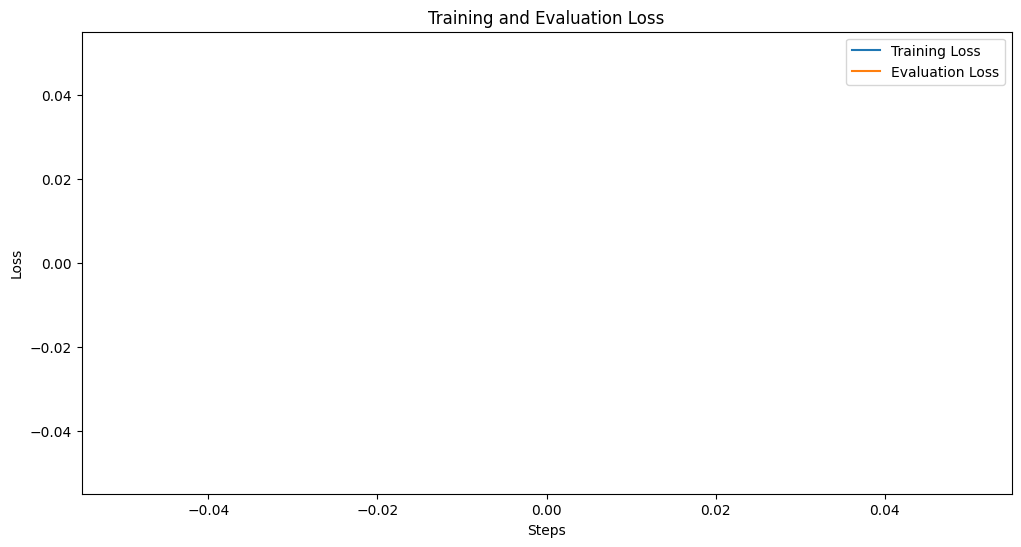

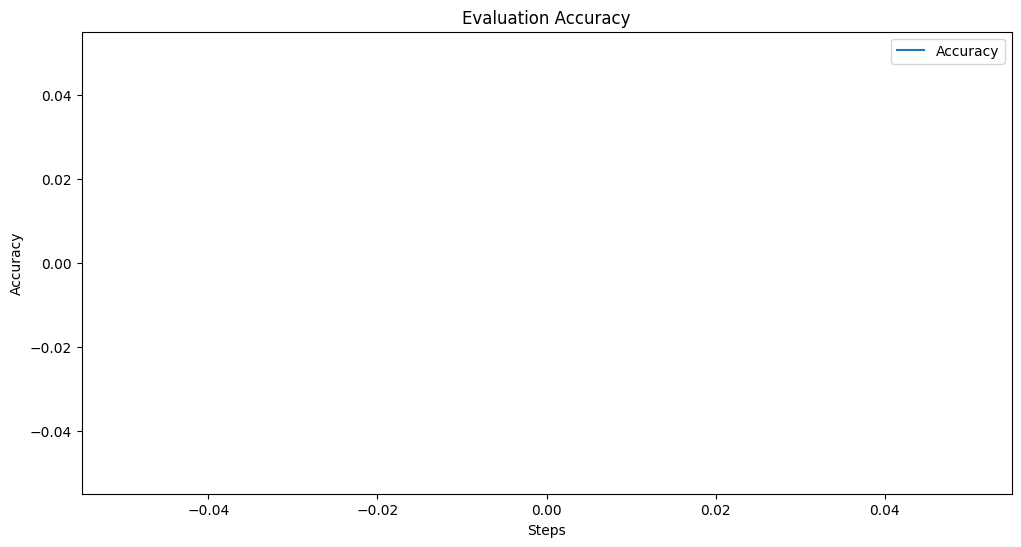

In [ ]:
# Visualize training loss and accuracy
training_logs = trainer.state.log_history

# Extract loss and accuracy
train_loss = [log['loss'] for log in training_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]
steps = [log['step'] for log in training_logs if 'step' in log]

# Ensure all lists have the same length
min_length = min(len(train_loss), len(eval_loss), len(accuracy), len(steps))
train_loss = train_loss[:min_length]
eval_loss = eval_loss[:min_length]
accuracy = accuracy[:min_length]
steps = steps[:min_length]

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, eval_loss, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(steps, accuracy, label='Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Ensure the model and inputs are on the same device
trainer.model.to(device)

# Move the evaluation dataset to the same device
trainer.eval_dataset = trainer.eval_dataset.map(lambda x: {k: v.to(device) for k, v in x.items()})

# Evaluate the model
results = trainer.evaluate()

# Print the results
print(f"Evaluation Results: {results}")



Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]


AttributeError: 'str' object has no attribute 'to'

In [ ]:
# Test the model on a sample job description
sample_job = "Looking for a data scientist skilled in machine learning and data analysis."
inputs = tokenizer(sample_job, return_tensors="pt", padding=True, truncation=True, max_length=512)
outputs = model(**inputs)
prediction = torch.argmax(outputs.logits, dim=-1)

# Output the prediction
print(f"Predicted label for sample job: {'AI skills required' if prediction.item() == 1 else 'No AI skills required'}")


Predicted label for sample job: No AI skills required
